We are interested in finding the state and control of the linear system (2.1) in the case where $\bar{h}=1$ et $\bar{\psi}=0$, $f_0=g_0=0$:
\begin{equation}
	\left\{
	\begin{aligned}
		&z_{t}-z_{xx} + n z=1_{\omega}v & & \text {in}\; \tilde{Q}, \\
		&z(-L,\cdot)=z(L,\cdot)=0  & & \text {in}\;(0,T), \\
		&k^{\prime}+2\mu z_{x}(1,\cdot)=0 & & \text {in}\;(0,T),  \\
		& k(0)=k_{0},\\
		& z(\cdot,0)=z_{0}, & &\text {in}\;(-L, L).
	\end{aligned}
	\right.
\end{equation}
We consider the following data:

$L=1$, $T=1$, $k_0=0.5$, $z_0(x)=\sin(\pi x)$ for $0\leq x\leq L$ and $0$ for $-L\leq x < 0$, We are looking to find a control $v$ such that : $z(x,T)=0, ∀ x\in (-L, L)$ and $k(T)=0$.

The control of the original system is obtained as $z_x(0, t)$, which acts in $x=0$.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Parameters

In [40]:
# Parameters
mu = 0.5  # Coefficient in the dynamic condition
L = 1    # Spatial domain (-1, 1)
T = 1   # Time domain (0, T)
n = -1    # parameter in the PDE
epsilon = 0.1 # for the control region
left_side_control = - L + epsilon # left-hand side for the control region
right_side_control = - epsilon # right-hand side for the control region
delta = 1e-6 # to avoid singularities
n= -1

### Networks for the state and control variables

In [41]:
# Network for the state z(x,t)
z_net = tf.keras.Sequential([
    tf.keras.layers.InputLayer((2,)),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1)
])

# Network for the state k(t)
k_net = tf.keras.Sequential([
    tf.keras.layers.InputLayer((1,)),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1)
])

# Network for the control v(x,t)
v_net = tf.keras.Sequential([
    tf.keras.layers.InputLayer((2,)),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1)
])


### Dataset for training and test (Training and test points)

In [42]:
# training: random points that follow a uniform distribution
N_x_training = 10000
N_t_training = 10000

x_sample_training = tf.random.uniform((N_x_training, 1), -L, L) # spatial interval (-L, L)
t_sample_training = tf.random.uniform((N_t_training, 1), 0, T)  # time interval (0, T)
xt_sample_training = tf.concat([x_sample_training, t_sample_training], axis=1) # (-L, L) x (0, T)
x_one_t_sample_training = tf.concat([tf.ones_like(t_sample_training), t_sample_training], axis=1) # x=1, 0<t<T
x_0_t_sample_training = tf.concat([tf.zeros_like(t_sample_training), t_sample_training], axis=1)  # x=0, 0<t<T

# test points
N_x_test = 1000
N_t_test = 1000

x_sample_test = tf.random.uniform((N_x_test, 1), -L, L)
t_sample_test = tf.random.uniform((N_t_test, 1), 0, T)
xt_sample_test = tf.concat([x_sample_test, t_sample_test], axis=1)
x_one_t_sample_test = tf.concat([tf.ones_like(t_sample_test), t_sample_test], axis=1)
x_0_t_sample_test= tf.concat([tf.zeros_like(t_sample_test), t_sample_test], axis=1)


### Losses for the ODE-PDE system

In [43]:
# initial conditions for z and k

def z_0(x): 
    return tf.where((x >= 0) & (x <= L), tf.sin(np.pi * x), tf.zeros_like(x))

def loss_z_0(sample_points, init_condition):
    z_init_pred = z_net(tf.concat([sample_points, tf.zeros_like(sample_points)], axis=1))
    return tf.reduce_mean(tf.square(z_init_pred - z_0(sample_points)))
#loss_z_0(x_sample_training, z_0)

k_0 = 0.5

def loss_k_0(k_0):
    t_init = tf.zeros((100, 1))
    k_init_pred = k_net(t_init)    
    return tf.sqrt(tf.reduce_mean(tf.square(k_init_pred - k_0)) + delta)

#loss_k_0(k_0)

In [44]:
# final conditions

def loss_z_T(sample_points):
  z_T_predict = z_net(tf.concat([sample_points, T * tf.ones_like(sample_points)], axis=1))
  return tf.reduce_mean(tf.square(z_T_predict)) # z(x, T)=0
#print(loss_z_T(x_sample_training))


def loss_k_T(t_final): 
  t_final = t_final * np.ones((100, 1))
  k_final_pred = k_net(t_final)

  return tf.sqrt(tf.reduce_mean(tf.square(k_final_pred)) + delta) #k(T)=0 
#loss_k_T(T)

In [45]:
# boundary conditions

def loss_boundary(sample_points):
    left_side_points = tf.concat([-L * tf.ones_like(sample_points), sample_points], axis=1)
    right_side_points = tf.concat([L * tf.ones_like(sample_points), sample_points], axis=1)
    return tf.reduce_mean(tf.square(z_net(left_side_points))) + tf.reduce_mean(tf.square(z_net(right_side_points))) # z(-1,t)=z(1,t)=0
#loss_boundary(t_sample_training)




In [46]:
# constraint z>=0

def smooth_max(x1, x2, beta=10):
    return (1.0 / beta) * tf.math.log(tf.exp(beta * x1) + tf.exp(beta * x2))

x_1 = tf.constant([0.])
def loss_z_non_negative(sample_points):
    return tf.reduce_mean(smooth_max(x_1, -z_net(sample_points)))
#loss_z_non_negative(xt_sample_training)


In [47]:
# PDE

def indicator_omega(sample_points, left_side_control, right_side_control):
    sample_points_indicator = sample_points[:, 0:1]
    return tf.where((sample_points_indicator > left_side_control) & (sample_points_indicator < right_side_control), tf.ones_like(sample_points), tf.zeros_like(sample_points))
   

def loss_pde(spatial_time_points, time_points, n):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(spatial_time_points)
            z_pred = z_net(spatial_time_points)
            k_pred = k_net(time_points)
            v_pred = v_net(spatial_time_points)
            #print(f"v_pred _shape = {v_pred.shape}")
            z_x = tape.gradient(z_pred, spatial_time_points)[:, 0:1]
            z_t = tape.gradient(z_pred, spatial_time_points)[:, 1:2]
            z_xx = tape.gradient(z_x, spatial_time_points)[:, 0:1]
        #print(f"indicator = {indicator_omega(x_sample_training, left_side_control, right_side_control)}")
        return tf.reduce_mean(tf.square(z_t - z_xx + n * z_pred - v_pred * indicator_omega(spatial_time_points, left_side_control, right_side_control)))
        
#loss_pde(xt_sample_training, t_sample_training, n)  

In [48]:
# ODE: k^{\prime}+2\mu z_{x}(1,\cdot)=0
def loss_ode(time_points):
    one_t_points = tf.concat([tf.ones_like(time_points), time_points], axis=1)
    with tf.GradientTape() as tape2:
      tape2.watch(one_t_points)      
      z_pred_boundary = z_net(one_t_points)
      z_x_boundary = tape2.gradient(z_pred_boundary, one_t_points)[:, 0:1]
    with tf.GradientTape() as tape3:
       tape3.watch(time_points)
       k_predict = k_net(time_points)
       k_t = tape3.gradient(k_predict, time_points)[:, 0:1]

    return tf.reduce_mean(tf.square(k_t + 2 * mu * z_x_boundary))
    
#loss_ode(t_sample_training)

In [49]:
# total loss function
def loss_add(sample_points, init_condition, k_0, x_sample_points, t_sample_points, t_final, n):
    loss_init_z = loss_z_0(x_sample_points, init_condition)
    loss_init_k = loss_k_0(k_0)
    loss_final_z = loss_z_T(x_sample_points)
    loss_final_k = loss_k_T(T)
    loss_z_constraint = loss_z_non_negative(sample_points)
    loss_pde_z = loss_pde(sample_points, t_sample_points, n)
    loss_dyn_k = loss_ode(t_sample_points)
    loss_boundary_final = loss_boundary(t_sample_points)
    loss_total = 10 * loss_init_z + 5 * loss_init_k + 50 * loss_final_z + 60 * loss_final_k  + 5 * loss_boundary_final + 10 * loss_pde_z + 5 * loss_dyn_k + 50 * loss_z_constraint
    
    return loss_total, loss_init_z, loss_init_k, loss_final_z, loss_final_k, loss_pde_z, loss_dyn_k, loss_boundary_final, loss_z_constraint
    
#loss_add(xt_sample_training, z_0, k_0, x_sample_training, t_sample_training, T, n)



### Training



In [50]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
@tf.function
def train_step():
    with tf.GradientTape() as tape4:
        loss_total, loss_init_z, loss_init_k, loss_final_z, loss_final_k, loss_pde_z, loss_dyn_k, loss_boundary, loss_z_constraint =  loss_add(
            xt_sample_training, z_0, k_0, x_sample_training, t_sample_training, T, n
            )                          
    gradients = tape4.gradient(loss_total, z_net.trainable_variables + k_net.trainable_variables + v_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, z_net.trainable_variables + k_net.trainable_variables + v_net.trainable_variables))
    loss_test, _, _, _, _, _, _, _, _ = loss_add(
            xt_sample_test, z_0, k_0, x_sample_test, t_sample_test, T, n
            ) 
    return loss_test, loss_total, loss_init_z, loss_init_k, loss_final_z, loss_final_k, loss_pde_z, loss_dyn_k, loss_boundary, loss_z_constraint
train_step()
    

(<tf.Tensor: shape=(), dtype=float32, numpy=16.150469>,
 <tf.Tensor: shape=(), dtype=float32, numpy=22.91558>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.28933555>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.500001>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.036237016>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.2198532>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.015556543>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.013541939>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.047999993>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.04111809>)

In [51]:
epochs = 20000
iterations, loss_history_train, loss_history_test = list(), list(), list()

for epoch in range(epochs):
    loss_test, loss_total, loss_init_z, loss_init_k, loss_final_z, loss_final_k, loss_pde, loss_dyn_k, loss_boundary, loss_z_constraint = train_step()
        
    if epoch % 1000 == 0:
        iterations.append(epoch)
        loss_history_train.append(loss_total)
        loss_history_test.append(loss_test)
        
        print(
            f"Epoch {epoch}: Loss_test = {loss_test.numpy():.4f}, Loss_total = {loss_total.numpy():.4f}, loss_init_z = {loss_init_z.numpy():.4f}, loss_init_k = {loss_init_k.numpy():.4f}, loss_final_z = {loss_final_z.numpy():.4f}, loss_final_k = {loss_final_k.numpy():.4f}, loss_pde = {loss_pde.numpy():.4f}, loss_dyn_k = {loss_dyn_k.numpy():.4f}, loss_boundary = {loss_boundary.numpy():.4f}, loss_z_constraint = {loss_z_constraint.numpy():.4f}"
            )
print(f"generalization error = {np.abs(loss_history_train[-1] - loss_history_test[-1])}")

Epoch 0: Loss_test = 10.0154, Loss_total = 16.0879, loss_init_z = 0.2598, loss_init_k = 0.5136, loss_final_z = 0.0170, loss_final_k = 0.1294, loss_pde = 0.0034, loss_dyn_k = 0.0072, loss_boundary = 0.0211, loss_z_constraint = 0.0426
Epoch 1000: Loss_test = 4.5284, Loss_total = 4.6016, loss_init_z = 0.1112, loss_init_k = 0.0309, loss_final_z = 0.0046, loss_final_k = 0.0032, loss_pde = 0.0506, loss_dyn_k = 0.1979, loss_boundary = 0.0670, loss_z_constraint = 0.0216
Epoch 2000: Loss_test = 4.2823, Loss_total = 4.3405, loss_init_z = 0.1002, loss_init_k = 0.0025, loss_final_z = 0.0038, loss_final_k = 0.0029, loss_pde = 0.0477, loss_dyn_k = 0.2080, loss_boundary = 0.0783, loss_z_constraint = 0.0210
Epoch 3000: Loss_test = 4.0839, Loss_total = 4.1138, loss_init_z = 0.0858, loss_init_k = 0.0023, loss_final_z = 0.0042, loss_final_k = 0.0027, loss_pde = 0.0469, loss_dyn_k = 0.2030, loss_boundary = 0.0833, loss_z_constraint = 0.0194
Epoch 4000: Loss_test = 3.9711, Loss_total = 3.9940, loss_init_z 

### Post-processing

In [52]:
# using LaTeX in the pictures that follow
plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for all text
    "font.family": "serif",  # Use serif font (default LaTeX style)
    "font.size": 12  # Adjust font size
})

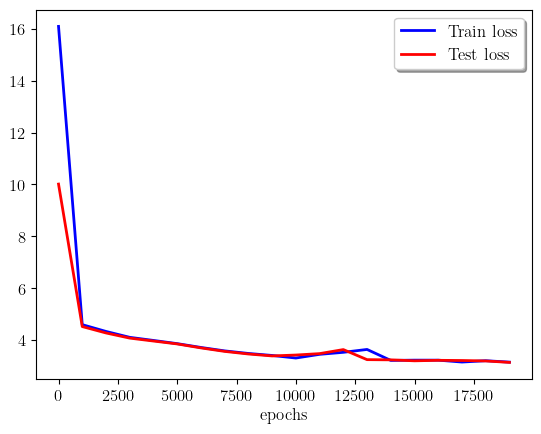

In [53]:
# convergence history

fig, ax = plt.subplots()
ax.plot(iterations, loss_history_train, '-', color='blue', linewidth=2, label=r'Train loss')
ax.plot(iterations, loss_history_test, '-', color='red', linewidth=2, label=r'Test loss')
ax.set(xlabel=r'epochs')
plt.legend(framealpha=1, shadow=True)
#plt.savefig('../figures/linear_convergence_history_n_minus_1.eps', format='eps')
plt.show()

1250/1250 [==============================] - 1s 497us/step


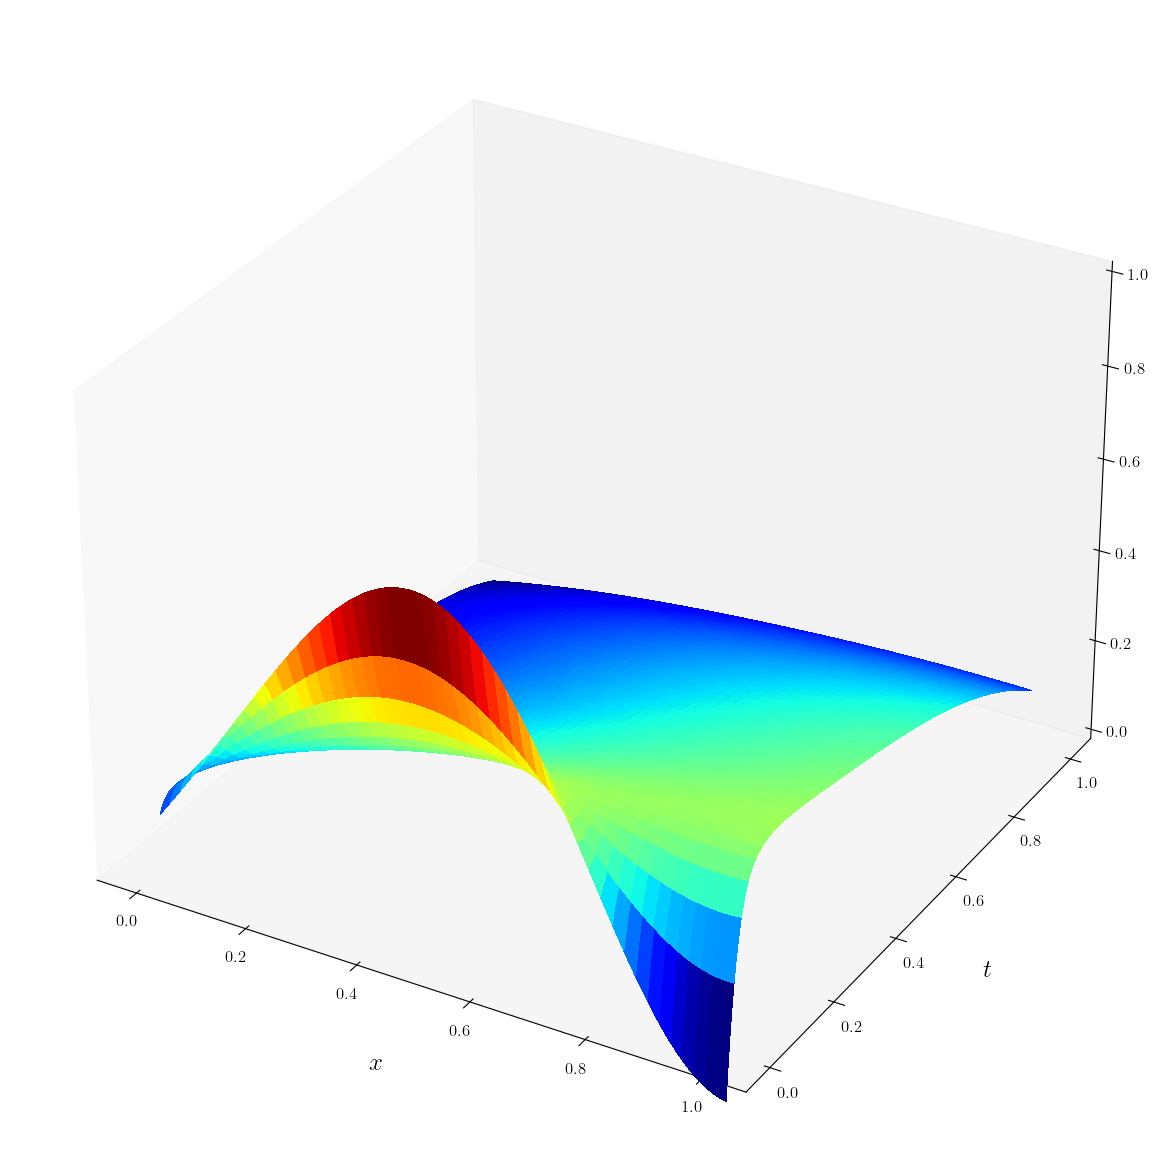

In [54]:
# Picture of z(x,t)

# Network evaluation
Nx, Nt = 200, 200  # Number of points for x ant t
x = np.linspace(0, L, Nx).reshape(-1, 1)
t = np.linspace(0, T, Nt).reshape(-1, 1)
X, T_grid = np.meshgrid(x, t)



xt_eval = np.hstack((X.flatten()[:, None], T_grid.flatten()[:, None]))
z_eval = z_net.predict(xt_eval).reshape(Nt, Nx)

#delta = 1e-2
tf.reduce_all(z_eval >= 0.001)

# Visualization

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
surf=ax.plot_surface(X, T_grid, z_eval, cmap='jet', linewidth=0, antialiased=False)
ax.grid(False)
ax.set_zlim(0, 1)
ax.set_xlabel(r'$x$', fontsize=18, color="black", labelpad=20)
ax.set_ylabel(r'$t$', fontsize=18, color="black", labelpad=20)
#plt.savefig('../figures/state_z_linear_controlled_n_minus_1.pdf', format='pdf')
plt.show()



313/313 [==============================] - 0s 484us/step


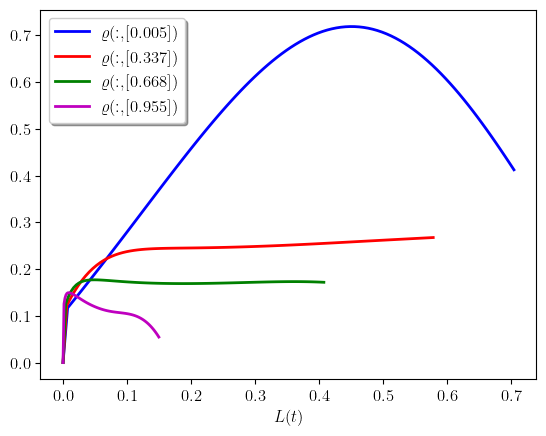

In [55]:
#T = 1
Nt_discrete = 100
Nx_discrete = 100
N_t = 200

k_eval = k_net(t).numpy()
L_eval = np.sqrt(k_eval)

discrete_time = np.array([t[1], t[67], t[133], t[190]])
y = np.array([L_eval[1], L_eval[67], L_eval[133], L_eval[190]])
xx_plot = np.zeros((4, Nx_discrete))
z_new = np.zeros((4, Nx_discrete))
for i in range(4):
    tt = np.linspace(0, discrete_time[i], Nt_discrete)     
    xx = np.linspace(0, y[i], Nx_discrete)
    xx_plot[i, :] = xx.T
    X_discrete, T_grid_discrete = np.meshgrid(xx, tt)
    xt_eval_discrete = np.hstack((X_discrete.flatten()[:, None], T_grid_discrete.flatten()[:, None]))
    z_eval_discrete = z_net.predict(xt_eval_discrete)    
    
    for j in range(len(xx)):
        z_new[i, j] = z_eval_discrete[j * 101]
    
z_new[0, 0] = 0
z_new[1, 0] = 0
z_new[2, 0] = 0
z_new[3, 0] = 0
plt.figure()
plt.plot(xx_plot[0, :], z_new[0, :], label=r'$\varrho(:,$' +f'{np.round(discrete_time[0], 3)}' + r'$)$', linewidth=2, color='b')
plt.plot(xx_plot[1, :], z_new[1, :], label=r'$\varrho(:,$' +f'{np.round(discrete_time[1], 3)}' + r'$)$', linewidth=2, color='r')
plt.plot(xx_plot[2, :], z_new[2, :], label=r'$\varrho(:,$' +f'{np.round(discrete_time[2], 3)}' + r'$)$',linewidth=2, color='g')
plt.plot(xx_plot[3, :], z_new[3, :], label=r'$\varrho(:,$' +f'{np.round(discrete_time[3], 3)}' + r'$)$', linewidth=2, color='m')
plt.xlabel('$L(t)$')
plt.legend(framealpha=1, shadow=True)
#plt.savefig('../figures/densities_linear_controlled_n_minus_1.pdf', format='pdf')




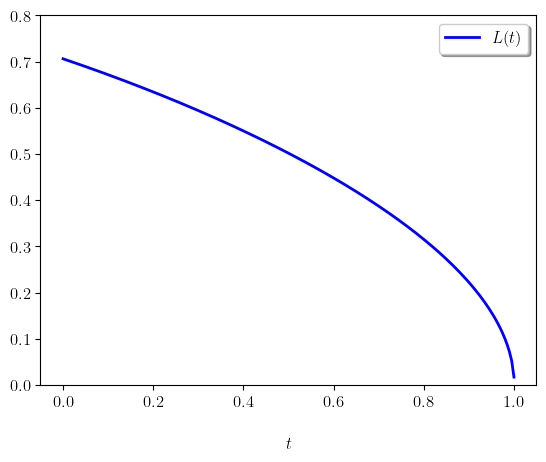

In [56]:

# Visualization 2D de L(t)
#L_eval = np.sqrt(k_eval)
plt.figure()
plt.plot(t, L_eval, label=r'$L(t)$', linewidth=2, color='blue')
plt.ylim(0, 0.8)
plt.xlabel(r'$t$', color="black", labelpad=20)
plt.legend(framealpha=1, shadow=True)
#plt.savefig('../figures/state_L_linear_controlled_n_minus_1.pdf', format='pdf')
plt.show()


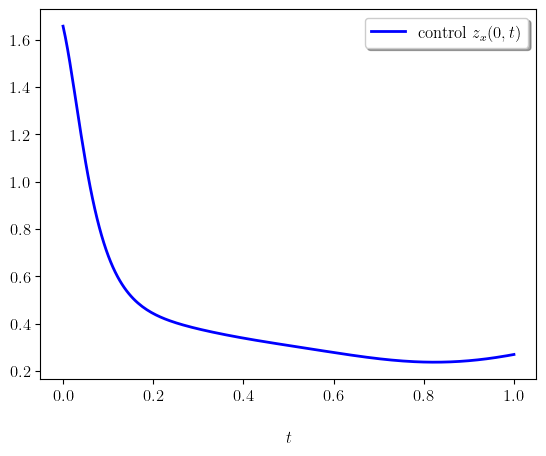

In [57]:
# Computation and visualization of z_x(0,t)
x_0_t_sample = tf.concat([tf.zeros_like(t), t], axis=1)
with tf.GradientTape() as tape2:
    tape2.watch(x_0_t_sample)
    z_pred_boundary = z_net(x_0_t_sample)
    z_x_boundary = tape2.gradient(z_pred_boundary, x_0_t_sample)[:, 0:1]
tt = np.linspace(0, T, 200).reshape(-1, 1)
plt.figure()
plt.plot(tt, z_x_boundary, label='control $z_x(0,t)$', linewidth=2, color='blue')
plt.xlabel('$t$', color="black", labelpad=20)
plt.legend(framealpha=1, shadow=True)
#plt.savefig('../figures/control_z_x_controlled_n_minus_1.pdf', format='pdf')
plt.show()